# Pronóstico de series de tiempo con RNN


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Métricas y preoprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Redes neuronales
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [21]:
# Cargamos el IPC de Guatemala y sus variaciones interanuales
data = pandas.read_csv('ipc-guatemala.csv')
data2000 = dataset.iloc[132:, :]
# Revisamos información de los últimos 6 meses
data2000.tail(6)

,Fecha,IPC,Var.IPC
350,Mar-19,139.11,4.171035
351,Apr-19,139.95,4.752994
352,May-19,140.32,4.536989
353,Jun-19,141.48,4.800000
354,Jul-19,141.40,4.369649
355,Aug-19,140.18,3.012934


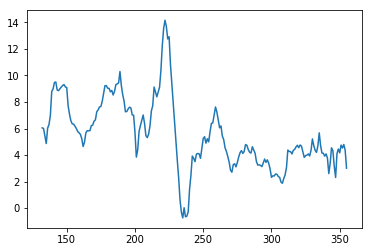

In [22]:
# Graficamos las variaciones interanuales históricas
plt.plot(data2000["Var.IPC"])

In [25]:
# Semilla 
np.random.seed(7)

In [32]:
# Configuramos el conjunto de datos
dataset = data2000["Var.IPC"].values.astype(np.float32)
dataset = np.reshape(dataset, (-1, 1))
dataset[-6:]

array([[4.171035 ],
       [4.752994 ],
       [4.5369887],
       [4.8      ],
       [4.3696485],
       [3.0129335]], dtype=float32)

In [33]:
# Normalizar el conjunto de resultados entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [34]:
dataset[:5]

array([[0.45572418],
       [0.45256087],
       [0.4138044 ],
       [0.37618515],
       [0.45424798]], dtype=float32)

In [35]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

150 74


In [36]:
dataset.shape, train.shape, test.shape

((224, 1), (150, 1), (74, 1))

In [39]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [62]:
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [63]:
trainX[:10]

array([[0.45572418, 0.45256087, 0.4138044 , 0.37618515, 0.45424798,
        0.4720123 ],
       [0.45256087, 0.4138044 , 0.37618515, 0.45424798, 0.4720123 ,
        0.51840067],
       [0.4138044 , 0.37618515, 0.45424798, 0.4720123 , 0.51840067,
        0.6391873 ],
       [0.37618515, 0.45424798, 0.4720123 , 0.51840067, 0.6391873 ,
        0.65287155],
       [0.45424798, 0.4720123 , 0.51840067, 0.6391873 , 0.65287155,
        0.68525934],
       [0.4720123 , 0.51840067, 0.6391873 , 0.65287155, 0.68525934,
        0.6875804 ],
       [0.51840067, 0.6391873 , 0.65287155, 0.68525934, 0.6875804 ,
        0.64679116],
       [0.6391873 , 0.65287155, 0.68525934, 0.6875804 , 0.64679116,
        0.6438372 ],
       [0.65287155, 0.68525934, 0.6875804 , 0.64679116, 0.6438372 ,
        0.6533717 ],
       [0.68525934, 0.6875804 , 0.64679116, 0.6438372 , 0.6533717 ,
        0.661517  ]], dtype=float32)

In [64]:
# The LSTM network expects the input data (X) to be provided with a 
# specific array structure in the form of: [samples, time steps, features].

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [65]:
trainX.shape

(143, 1, 6)

In [66]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [67]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.58 RMSE
Test Score: 0.59 RMSE


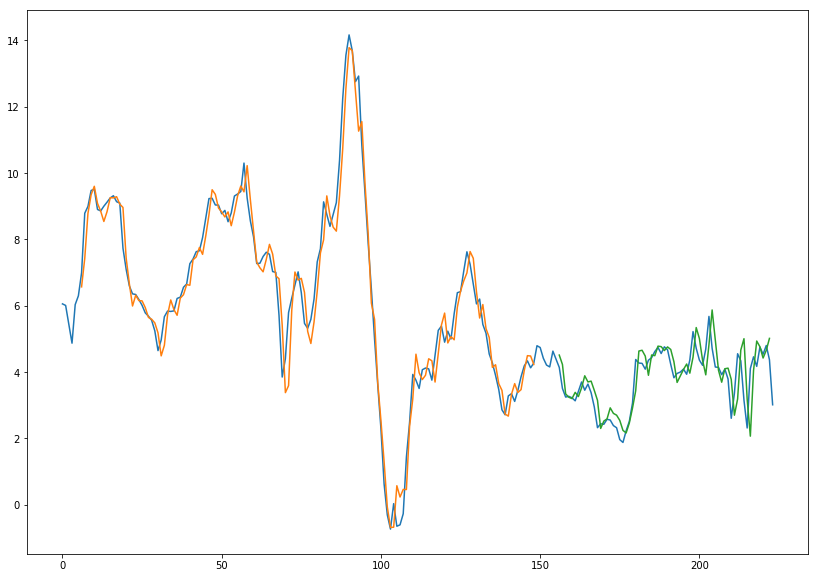

In [68]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(14,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()